#### Initial load

In [1]:
#Initial load
from RedDownloader import RedDownloader
import praw
import requests
import re
import os
import urllib.request
from PIL import Image
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from sklearn import metrics
import sys
import sklearn
from torchvision import datasets, transforms, utils
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score, train_test_split
from scipy.stats import uniform
import random
import torchvision.models as models
import torch
import torch.nn as n
from torch.utils.data import DataLoader
import torchvision.models as models
from operator import itemgetter
import torch
from torch.utils.data import Dataset





#### Load data

In [2]:
def ImageWithScore(img_path, csv):
    data_path = pd.read_csv(csv)
    transformed_images = []
    scores = []
    corrupted = []
    counter = 0

    for index, row in data_path.iterrows():
        if counter % 1000 == 0:
            print('Current progress is at: {count}'.format(count=counter))

        submission_id = row['PostID'] + ".jpg"
        score = np.log10(row['AppliedScale']) #Choose target here!!
        image_path = os.path.join(img_path, submission_id)
        image_path = os.path.join(image_path).replace("\\", "/")
        if os.path.exists(image_path):
            try:
                with Image.open(image_path) as image:
                    # Normalize to mean and std of ImageNet
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

                    transformed_image = transform(image)
                    transformed_images.append(transformed_image)
                    scores.append(score)
                    counter += 1
            except Exception as e:
                print(f'Image failed: {submission_id}: {e}')
                corrupted.append(submission_id)
                counter += 1
        else:
            print(f'Image not found: {image_path}')
            counter += 1

    return transformed_images, scores

image_path = "C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3"
data_path = 'C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/RedditDataWithLinks4.csv'

transformed_images, scores = ImageWithScore(image_path, data_path)

Current progress is at: 0
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/swphj.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/swh4g.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/sw672.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/sw5ng.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svtg5.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svtbd.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svlbb.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svffq.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svf6n.jpg
Image not found: C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/Images3/svc81.jpg
Image not found: C:/User

#### Split into test/train

In [3]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_scores, test_scores = train_test_split(transformed_images, scores, test_size=0.2, random_state=42)

train_data = list(zip(train_images, train_scores))
test_data = list(zip(test_images, test_scores))


#### Load data properly for pytorch

In [4]:

class Loader(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, score = self.data[index]
        return image, score


In [5]:
train_loader = torch.utils.data.DataLoader(Loader(train_data), batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(Loader(test_data), batch_size=10, shuffle=False)

#### Cuda or CPU

In [6]:
# Use GPU if available - much faster.    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Transfer learning CNN

In [ ]:
def CNN(learning_rate, batch_size, num_epochs):
#Load ResNet, freeze parameters and change it to regression task
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad = False
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, 1)
    resnet.to(device)
    
    # Define the criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)
    
    # Train the model
    resnet.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        
        for images, scores in train_loader:
            images = images.to(device)
            scores = scores.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = resnet(images)
            loss = criterion(outputs, scores.unsqueeze(1).float())
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluate on the test set
        resnet.eval()
        total_test_loss = 0
        
        with torch.no_grad():
            for images, scores in test_loader:
                images = images.to(device)
                scores = scores.to(device)
                
                # Forward pass
                outputs = resnet(images)
                loss = criterion(outputs, scores.unsqueeze(1).float())
                
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    print("Finished training.")
    
    return resnet, train_losses, test_losses

model, train_losses, test_losses = CNN(learning_rate=1e-3, batch_size=50, num_epochs=20)


#### SAVE THE MODEL

In [ ]:
torch.save(model.state_dict(), "C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth")

#### Predict on test data

In [19]:
# Load model and change last layer and evaluate
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth"))
model.to(device)
model.eval()

predicted_scores = []
originals = []
predictions = []

with torch.no_grad():
    for images, scores in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted_scores.extend(outputs.squeeze().cpu().numpy())

        # Make tuples for sorting easily
        original_tuples = list(zip(images, scores))
        originals.extend(original_tuples)
        predicted_tuples = list(zip(images, outputs.squeeze().cpu().numpy()))
        predictions.extend(predicted_tuples)


#### Calculate correlation

In [20]:
predicted_score = np.array(predicted_scores)
actual_scores = np.array(test_scores)

correlation_coefficient = np.corrcoef(actual_scores, predicted_scores)
print(correlation_coefficient)


[[1.         0.09145406]
 [0.09145406 1.        ]]


#### Plots

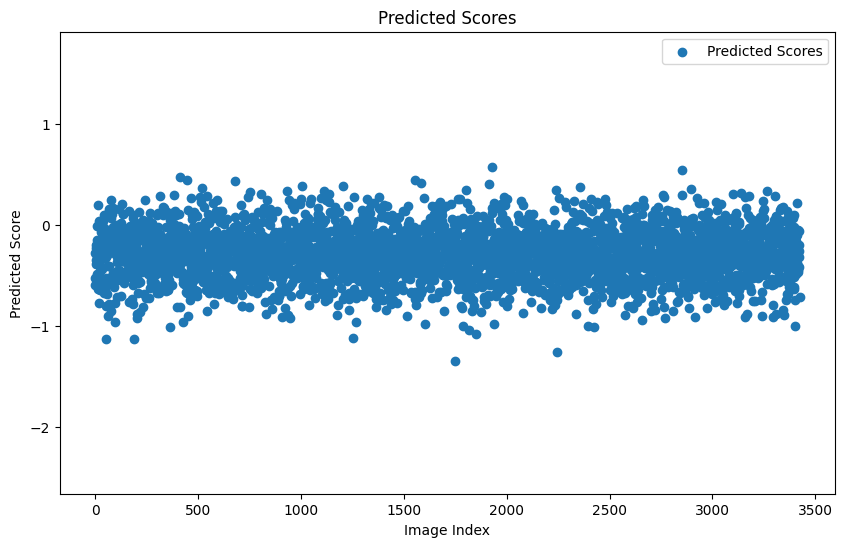

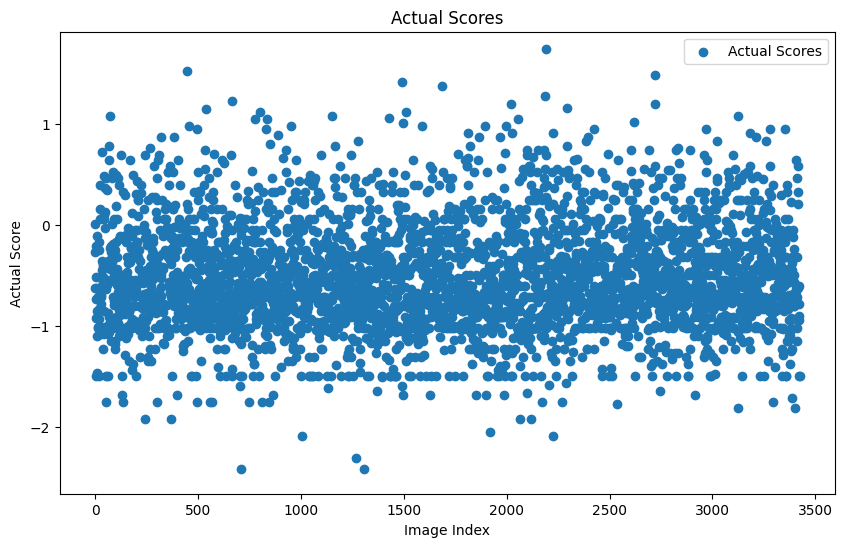

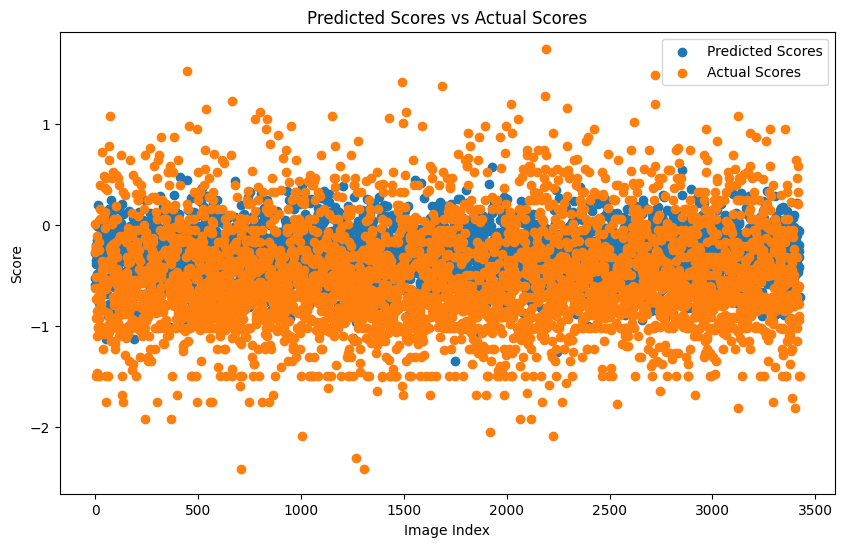

In [21]:
min_score = min(np.min(predicted_scores), np.min(actual_scores))
max_score = max(np.max(predicted_scores), np.max(actual_scores))
y_min, y_max = min_score * 1.1, max_score * 1.1  # Adjust the factor as needed

predicted_scores = np.array(predicted_scores)
actual_scores = np.array(test_scores)

# Plotting the predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_scores)), predicted_scores, label='Predicted Scores')
plt.xlabel('Image Index')
plt.ylabel('Predicted Score')
plt.title('Predicted Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# Plotting the actual scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_scores)), actual_scores, label='Actual Scores')
plt.xlabel('Image Index')
plt.ylabel('Actual Score')
plt.title('Actual Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

#Plotting predicted scores and actual 
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_scores)), predicted_scores, label='Predicted Scores')
plt.scatter(range(len(actual_scores)), actual_scores, label='Actual Scores')
plt.xlabel('Image Index')
plt.ylabel('Score')
plt.title('Predicted Scores vs Actual Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


#### Histogram of original distribution

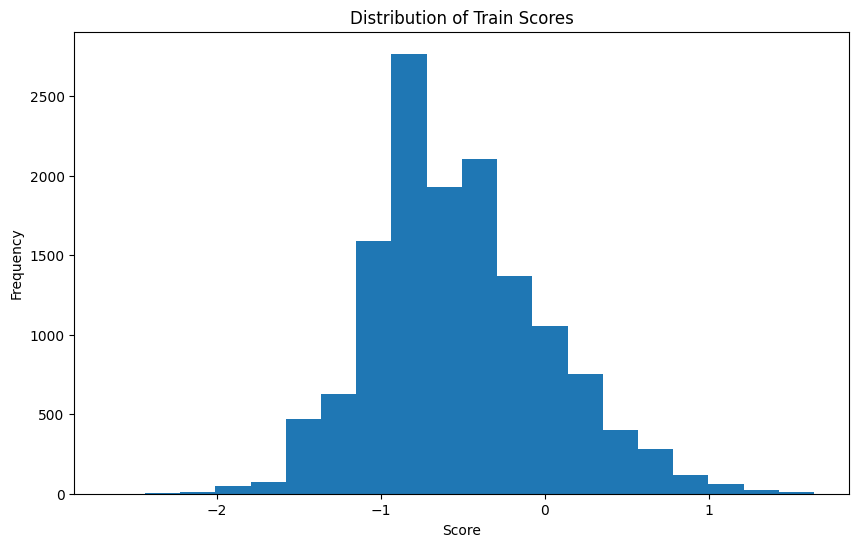

In [22]:

plt.figure(figsize=(10, 6))
plt.hist(train_scores, bins=20)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Train Scores')
plt.show()


#### Images with highest and lowest score

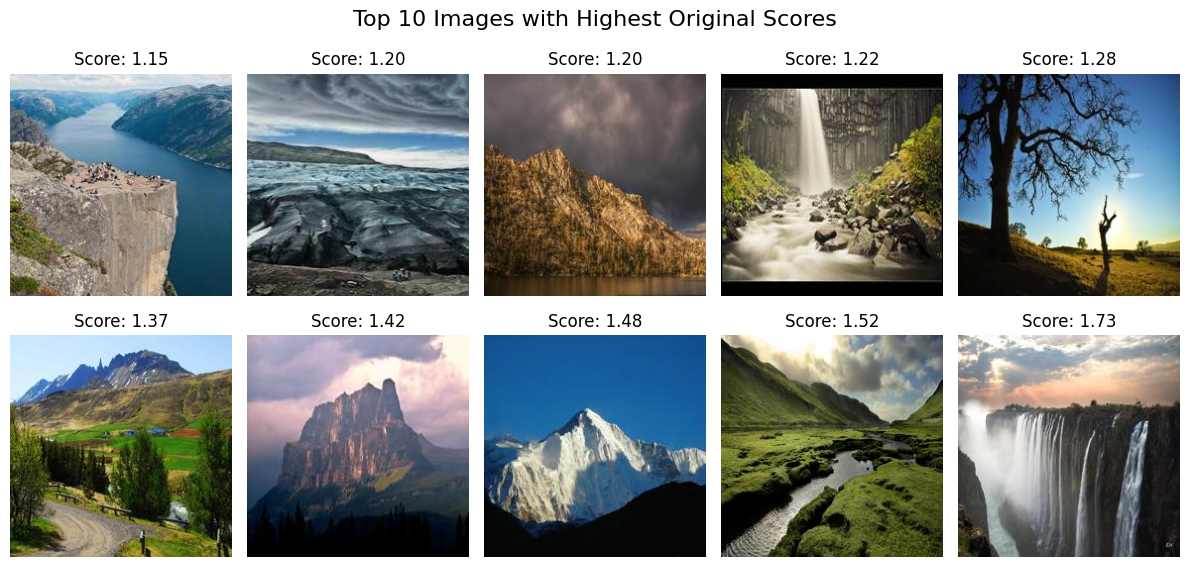

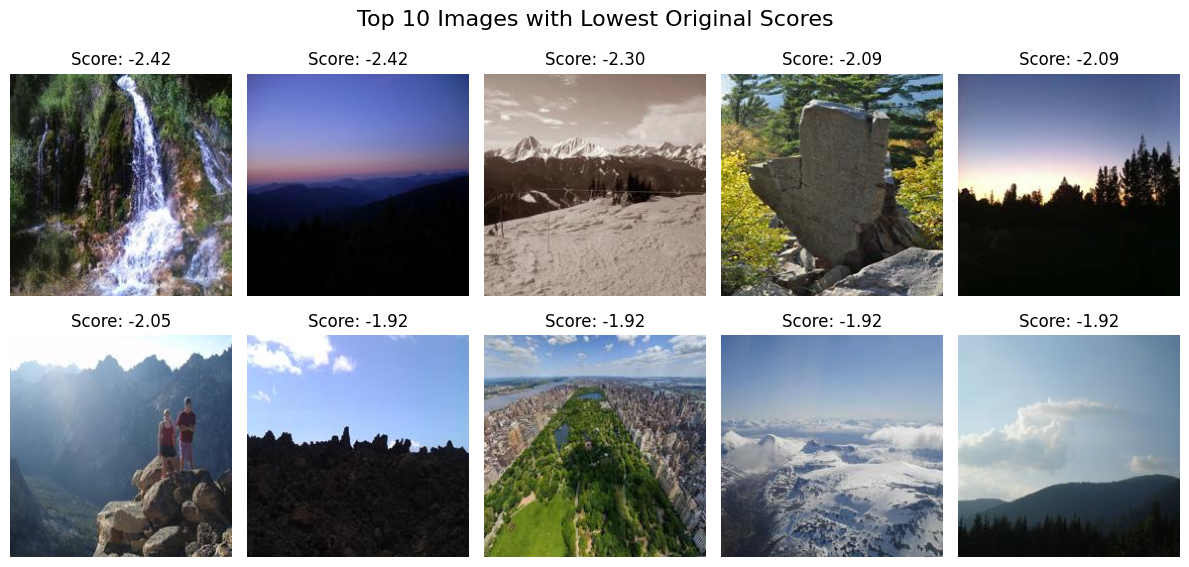

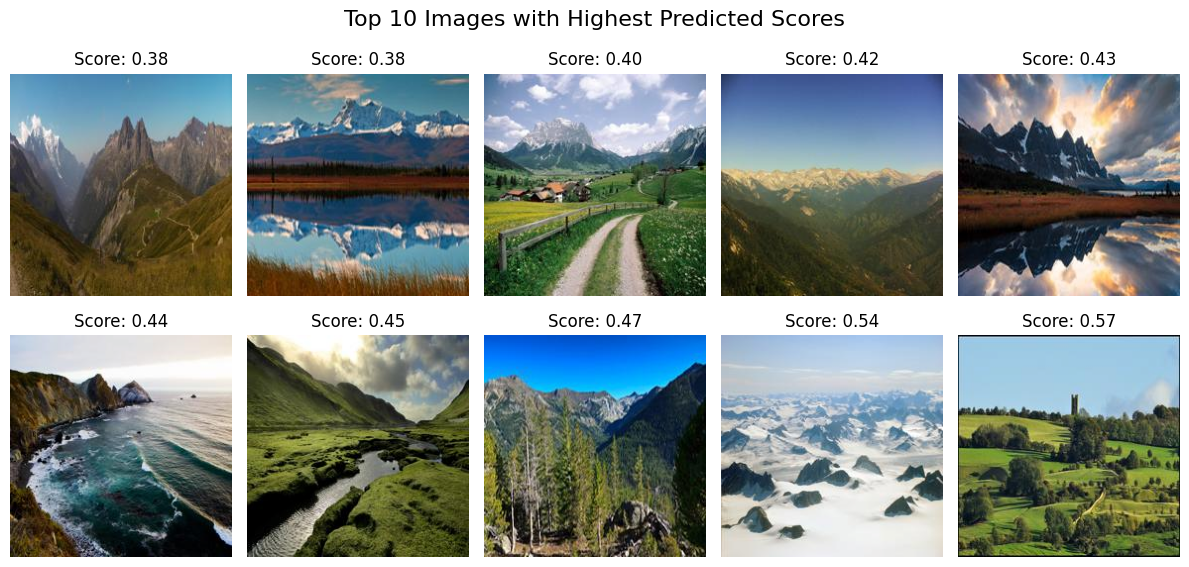

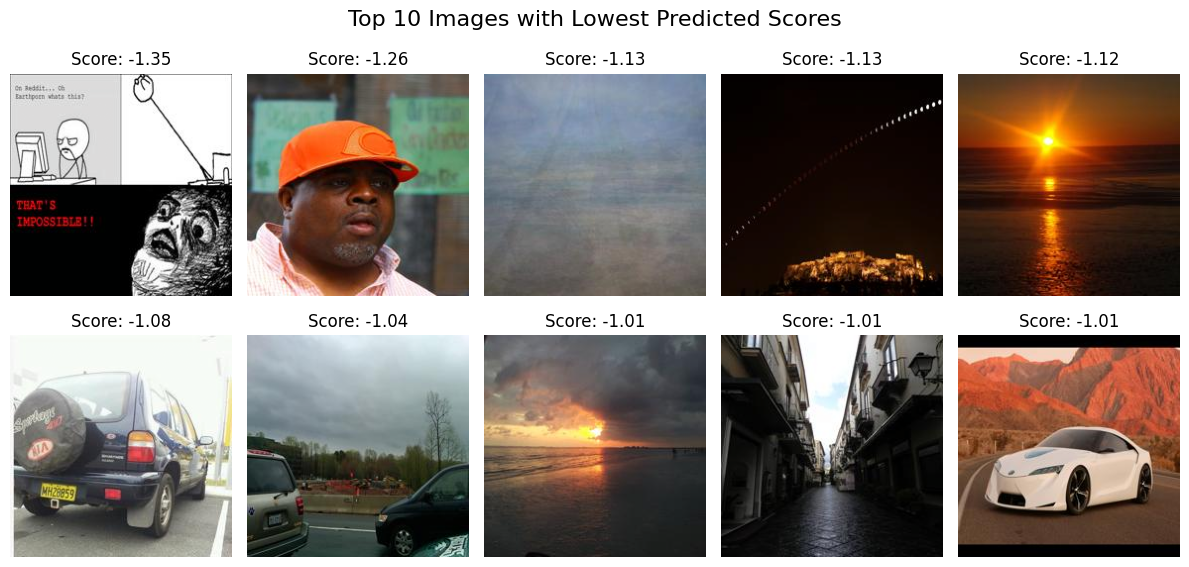

In [23]:
#Inverse ImageNet normalisation
normalise_inverse = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

sorted_original_data = sorted(originals, key=lambda x: x[1])
sorted_predicted_data = sorted(predictions, key=lambda x: x[1])

top_10_high_original = sorted_original_data[-10:]
top_10_low_original = sorted_original_data[:10]

top_10_high_predicted = sorted_predicted_data[-10:]
top_10_low_predicted = sorted_predicted_data[:10]

def plot_images_with_scores(images, scores, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    for i, (image, score) in enumerate(zip(images, scores)):
        denormalized_image = normalise_inverse(image)
        plt.subplot(2, 5, i + 1)
        plt.imshow(denormalized_image.permute(1, 2, 0).cpu().numpy())
        plt.title(f"Score: {score.item():.2f}") 
        plt.axis('off')
    plt.tight_layout()
    plt.show()

predicted_scores = [score.item() for _, score in predictions]


plot_images_with_scores([image for image, _ in top_10_high_original], [score for _, score in top_10_high_original], "Top 10 Images with Highest Original Scores")
plot_images_with_scores([image for image, _ in top_10_low_original], [score for _, score in top_10_low_original], "Top 10 Images with Lowest Original Scores")
plot_images_with_scores([image for image, _ in top_10_high_predicted], [score for _, score in top_10_high_predicted], "Top 10 Images with Highest Predicted Scores")
plot_images_with_scores([image for image, _ in top_10_low_predicted], [score for _, score in top_10_low_predicted], "Top 10 Images with Lowest Predicted Scores")


#### Test model on actual top and bottom 10

In [24]:
test_images = [image for image, _ in top_10_high_original]

predicted_scores_top_10 = []

with torch.no_grad():
    for image in test_images:
        image = image.to(device)
        output = model(image.unsqueeze(0))
        predicted_scores_top_10.append(output.item())

print("Top 10 Actual and Predicted Scores:")
for i, (image, actual_score) in enumerate(top_10_high_original):
    predicted_score = predicted_scores_top_10[i]
    print(f"Image {i+1}: Actual Score = {actual_score:.2f}, Predicted Score = {predicted_score:.2f}")


Top 10 Actual and Predicted Scores:
Image 1: Actual Score = 1.15, Predicted Score = -0.35
Image 2: Actual Score = 1.20, Predicted Score = -0.61
Image 3: Actual Score = 1.20, Predicted Score = -0.13
Image 4: Actual Score = 1.22, Predicted Score = -0.15
Image 5: Actual Score = 1.28, Predicted Score = -0.28
Image 6: Actual Score = 1.37, Predicted Score = 0.14
Image 7: Actual Score = 1.42, Predicted Score = -0.37
Image 8: Actual Score = 1.48, Predicted Score = 0.14
Image 9: Actual Score = 1.52, Predicted Score = 0.45
Image 10: Actual Score = 1.73, Predicted Score = -0.18


In [25]:
test_images = [image for image, _ in top_10_low_original]

predicted_scores_bottom_10 = []

with torch.no_grad():
    for image in test_images:
        image = image.to(device)
        output = model(image.unsqueeze(0))
        predicted_scores_bottom_10.append(output.item())

print("Bottom 10 Actual and Predicted Scores:")
for i, (image, actual_score) in enumerate(top_10_low_original):
    predicted_score = predicted_scores_bottom_10[i]
    print(f"Image {i+1}: Actual Score = {actual_score:.2f}, Predicted Score = {predicted_score:.2f}")


Bottom 10 Actual and Predicted Scores:
Image 1: Actual Score = -2.42, Predicted Score = -0.40
Image 2: Actual Score = -2.42, Predicted Score = -0.44
Image 3: Actual Score = -2.30, Predicted Score = -0.96
Image 4: Actual Score = -2.09, Predicted Score = -0.23
Image 5: Actual Score = -2.09, Predicted Score = -0.63
Image 6: Actual Score = -2.05, Predicted Score = -0.59
Image 7: Actual Score = -1.92, Predicted Score = -0.24
Image 8: Actual Score = -1.92, Predicted Score = -0.13
Image 9: Actual Score = -1.92, Predicted Score = -0.26
Image 10: Actual Score = -1.92, Predicted Score = -0.63


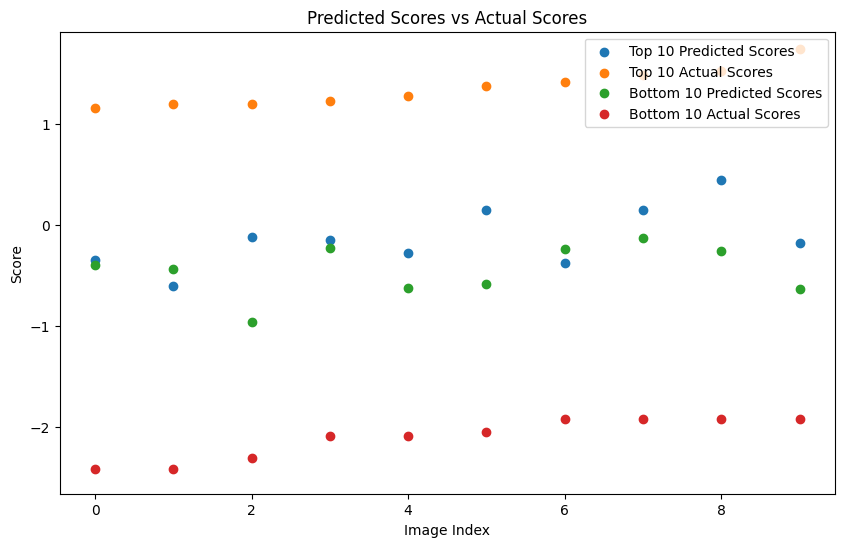

In [28]:
actual_scores_top_10 = [score for _, score in top_10_high_original]
actual_scores_bottom_10 = [score for _, score in top_10_low_original]

# Make sure you've run previous plots so y_min and y_max is defined. Keeps the scale

plt.figure(figsize=(10, 6))
plt.scatter(range(len(predicted_scores_top_10)), predicted_scores_top_10, label='Top 10 Predicted Scores')
plt.scatter(range(len(actual_scores_top_10)), actual_scores_top_10, label='Top 10 Actual Scores')
plt.scatter(range(len(predicted_scores_bottom_10)), predicted_scores_bottom_10, label='Bottom 10 Predicted Scores')
plt.scatter(range(len(actual_scores_bottom_10)), actual_scores_bottom_10, label='Bottom 10 Actual Scores')
plt.xlabel('Image Index')
plt.ylabel('Score')
plt.title('Predicted Scores vs Actual Scores')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()




#### Extract features (Highest upvoted)

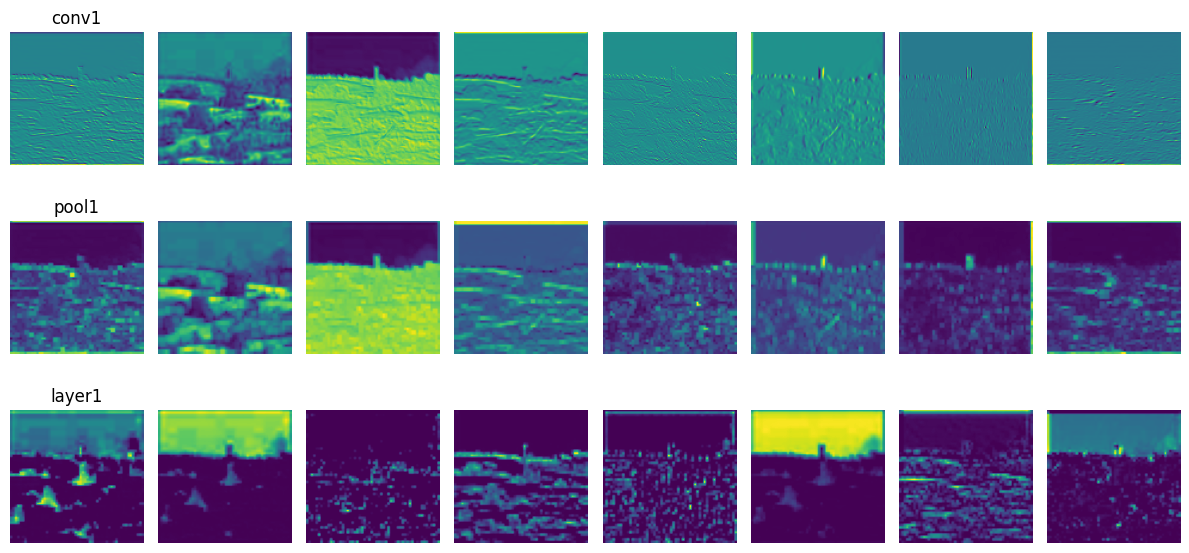

In [35]:
# Load the pre-trained model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth"))
model.to(device)

highest_score_image = top_10_high_predicted[-1][0]
input_tensor = highest_score_image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    # Visualize activation map for conv1
    conv1_features = model.conv1(input_tensor)
    conv1_activation_maps = conv1_features.squeeze(0).cpu().numpy()

    # Visualize activation map for pool1
    pool1_features = model.maxpool(conv1_features)
    pool1_activation_maps = pool1_features.squeeze(0).cpu().numpy()

    # Visualize activation map for layer1
    layer1_features = model.layer1(pool1_features)
    layer1_activation_maps = layer1_features.squeeze(0).cpu().numpy()

# Visualize the activation maps
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(12, 6))

# Visualize conv1 activation maps
for i, ax in enumerate(axes[0]):
    ax.imshow(conv1_activation_maps[i])
    ax.axis('off')
axes[0, 0].set_title('conv1')

# Visualize pool1 activation maps
for i, ax in enumerate(axes[1]):
    ax.imshow(pool1_activation_maps[i])
    ax.axis('off')
axes[1, 0].set_title('pool1')

# Visualize layer1 activation maps
for i, ax in enumerate(axes[2]):
    ax.imshow(layer1_activation_maps[i])
    ax.axis('off')
axes[2, 0].set_title('layer1')

plt.tight_layout()
plt.show()


#### Extract features (Lowest upvoted)

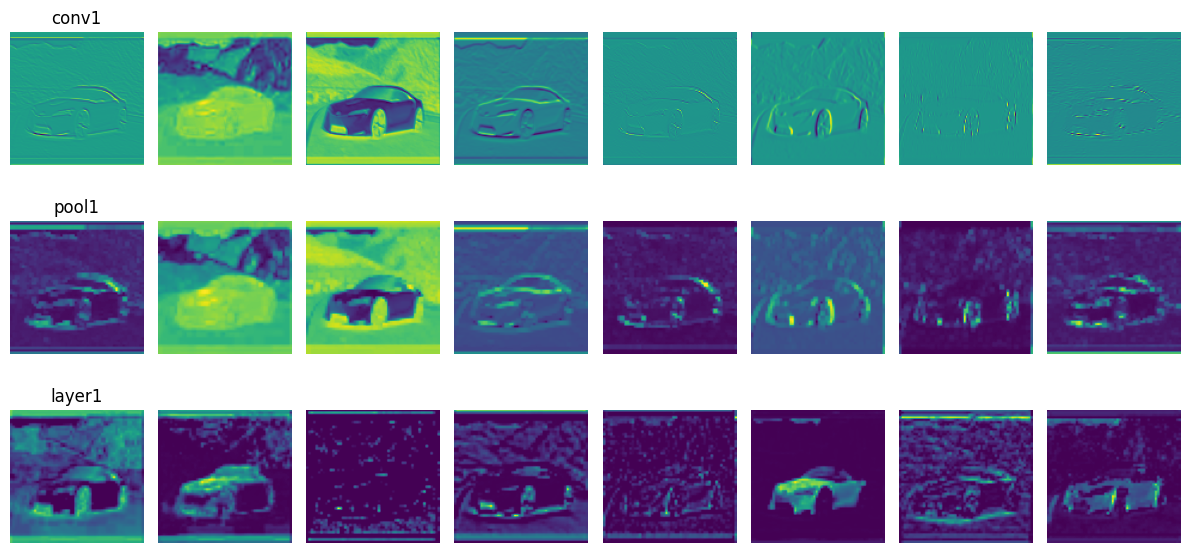

In [36]:
# Load the pre-trained model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("C:/Users/Chris/Desktop/DTU/4. Semester/02466 - Project Work/2ResNet50b20elr3.pth"))
model.to(device)

lowest_score_image = top_10_low_predicted[-1][0]
input_tensor = lowest_score_image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    # Visualize activation map for conv1
    conv1_features = model.conv1(input_tensor)
    conv1_activation_maps = conv1_features.squeeze(0).cpu().numpy()

    # Visualize activation map for pool1
    pool1_features = model.maxpool(conv1_features)
    pool1_activation_maps = pool1_features.squeeze(0).cpu().numpy()

    # Visualize activation map for layer1
    layer1_features = model.layer1(pool1_features)
    layer1_activation_maps = layer1_features.squeeze(0).cpu().numpy()

# Visualize the activation maps
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(12, 6))

# Visualize conv1 activation maps
for i, ax in enumerate(axes[0]):
    ax.imshow(conv1_activation_maps[i])
    ax.axis('off')
axes[0, 0].set_title('conv1')

# Visualize pool1 activation maps
for i, ax in enumerate(axes[1]):
    ax.imshow(pool1_activation_maps[i])
    ax.axis('off')
axes[1, 0].set_title('pool1')

# Visualize layer1 activation maps
for i, ax in enumerate(axes[2]):
    ax.imshow(layer1_activation_maps[i])
    ax.axis('off')
axes[2, 0].set_title('layer1')

plt.tight_layout()
plt.show()
